In [2]:
from mpl_toolkits.mplot3d import Axes3D
import pathlib
from scipy import interpolate as interp
from scipy import integrate as integ
import pythtb as pytb
import scipy.linalg as la
import astropy as aspy

import sim_tb as stb
import bz_utilities as bzu
import toy_models as toy
import plot_utils as pltu
import linear_response as lr
import analytical_models as amod
%matplotlib notebook



## Physical units

In [3]:
eV_2_Joule = 1.602e-19 # 1eV = 1.602e-19 J
hbar = 6.582119569e-16 # eVs
m_e = 9.109e-31 # Kg
m = 0.32 * m_e
A =  hbar**2 / m # eV**2 s**2 / Kg
A = A * eV_2_Joule *1e18 # eV nm**2

#-----------------------------------------------
e = 1.602177e-19 # C
hbar_Js = 1.054571e-34 # Js
factor_e = e**2 / hbar_Js # e = factor_e (hbar/e) Ohm^{-1}
#-----------------------------------------------
# Factor to recover physical units in spin conductivity
# (should be (2pi)**2, but Mook2020 uses the 3d factor)
factor_s = factor_e  / (2*np.pi)**3

# Rashba simulation

E min = -283.0 meV
Es = -83.0 meV
Ed = 14.0 meV
Regime: Small field


<IPython.core.display.Javascript object>


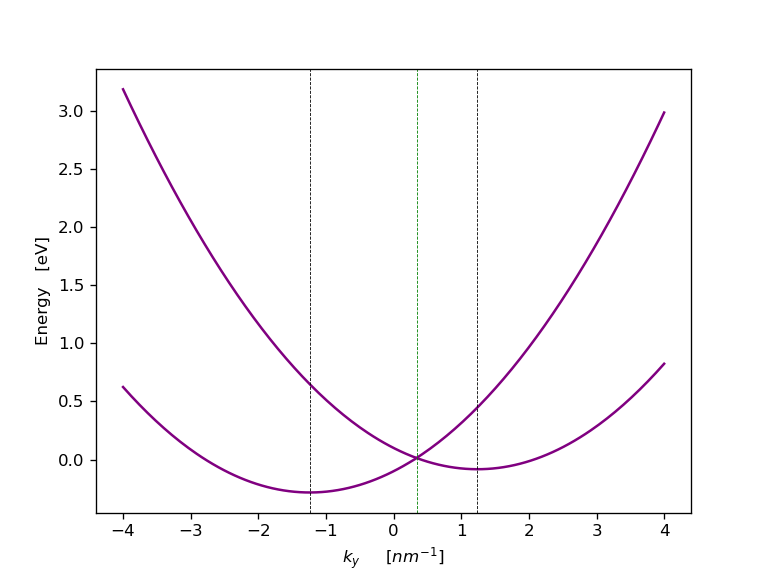

In [4]:
alpha, B = 0.295, 0.1
kmax = 3
lamb = 0.0
th, phi = np.pi/2, 0
path = amod.create_path_rashba_model("", alpha, B=B, th=th, phi=phi, lamb=lamb)
Sim_rash = amod.Rashba_model(path, alpha, B=B, th=th, phi=phi, lamb=lamb)



def print_mssg(alpha, B):
    """
    Print informative message about relevant energies, and tthe corresponding
    regime: Small field or High field.
    """
    factor = 0.238
    e_min= - alpha**2  /factor / 2 - B
    e_s = - alpha**2  / factor / 2 + B
    e_d = factor / 2 * (B/alpha)**2
    print("E min = {} meV".format(np.round(e_min*1e3)))
    print("Es = {} meV".format(np.round(e_s*1e3)))
    print("Ed = {} meV".format(np.round(e_d*1e3)))
    critiq = alpha**2/B / factor
    str_regime = "Small field" if critiq > 1 else "High field"
    print("Regime: {}".format(str_regime))
    
print_mssg(alpha, B)
fig, ax = plt.subplots()
Sim_rash.plot_bands_1d(ax, nk=200)


## 2d colormap of band structure

<IPython.core.display.Javascript object>


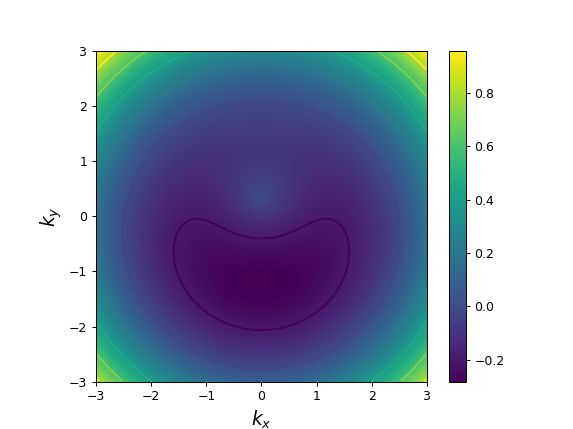

<IPython.core.display.Javascript object>


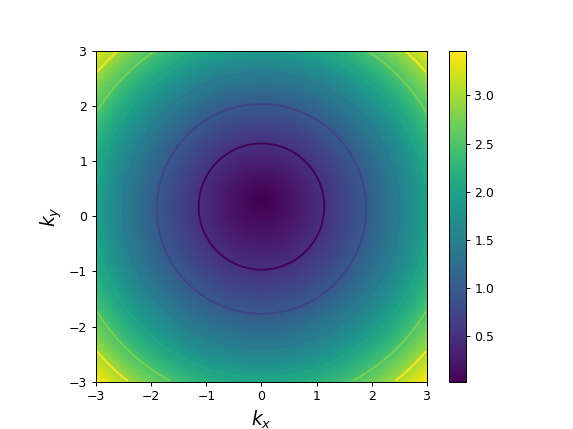

In [11]:
Sim_rash.create_bands_grid(kmax=kmax, nk=200)
fig, ax = plt.subplots()
Sim_rash.plot_bands_2d(fig, ax, 0, kmax=kmax, cmap="viridis")

fig2, ax2 = plt.subplots()
Sim_rash.plot_bands_2d(fig2, ax2, 1, kmax=kmax, cmap="viridis")

plt.show()

In [3]:
components = (2,0,1)
Gamma = 12.7e-3 # 12.7 meV
Ef = 0.0
kmax = 1
kx = np.linspace(-kmax, kmax, 100)
s_cond = np.zeros_like(kx)
s_cond2 = np.zeros_like(kx)
for i in range(100):
    s_cond[i] = Sim_rash.spin_conductivity_k(kx[i], 0, Ef, *components, Gamma)
    s_cond2[i] = Sim_rash.spin_conductivity_k(0, kx[i], Ef, *components, Gamma)
    
fig, ax = plt.subplots()
ax.plot(kx, s_cond)
ax.plot(kx, s_cond2)

NameError: name 'Sim_rash' is not defined

<IPython.core.display.Javascript object>


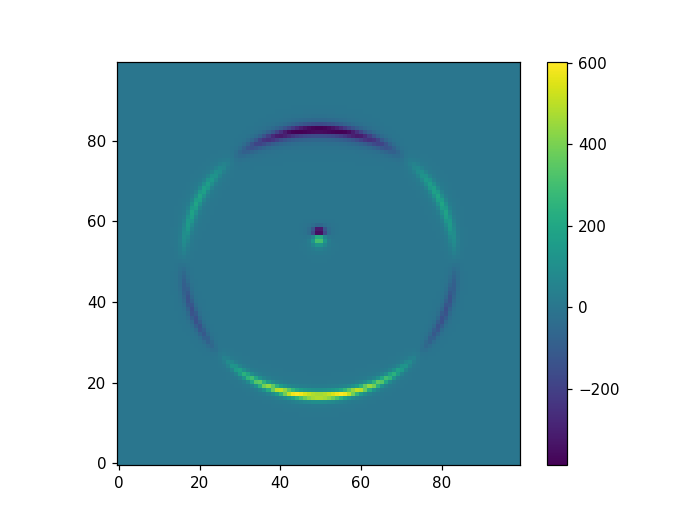

extent:  [-0.5, 0.5, -0.5, 0.5]
sigma_yxy 1.8297164299487179


In [13]:
Ef = 0.025#-79.6e-3
Gamma = 30e-3#12.7e-3
kmax = 0.5
nk = 100
#k = np.linspace(-kmax, kmax, nk)
#kx, ky = np.meshgrid(k,k)
kx_min, kx_max, ky_min, ky_max = amod.limits_k_occup(Ef, alpha, B, 0, factor=1.5)
kkx = np.linspace(kx_min, kx_max, nk)
kky = np.linspace(ky_min, ky_max, nk)
kx, ky = np.meshgrid(kkx, kky)
Sim_rash.mode_s_cond = "zelezny_intra"
s_cond = np.zeros_like(kx)
for x in range(nk):
    for y in range(nk):
        s_cond[x,y] = Sim_rash.spin_conductivity_k(kx[x,y], ky[x,y], Ef, 1,0,1, Gamma)
        
        
        
fig, ax = plt.subplots()

extent = [-kmax, kmax, -kmax, kmax]
print("extent: ", extent)
img = ax.imshow(s_cond, origin="lower", cmap="viridis")#, extent = extent)
plt.colorbar(img)

integ_s_cond = integ.simps([integ.simps(s_cond_1d,kky) for s_cond_1d in s_cond],kkx)
print("sigma_yxy",integ_s_cond)

<IPython.core.display.Javascript object>


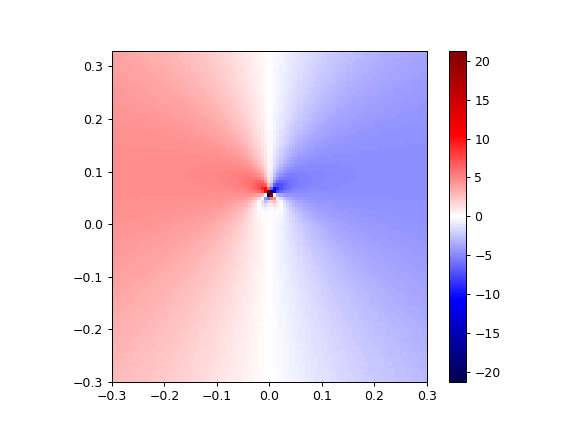

In [132]:
kx, ky = 0.0, 0.0
i, n = 0, 0

kmax = 0.3
nk = 100
k = np.linspace(-kmax, kmax, nk)
kx, ky = np.meshgrid(k,k)
vorticity = np.zeros_like(kx)
s_current = np.zeros_like(kx)
for x in range(nk):
    for y in range(nk):
        vorticity[x,y] = Sim_rash.vorticity(kx[x,y], ky[x,y], i, n)
        #s_current[x,y] = Sim_rash.spin_current(kx[x,y], ky[x,y], n, i, 1)
        
fig, ax = plt.subplots()
extent = [-kmax, kmax, -kmax, kmax*1.1]
img = ax.imshow(vorticity, origin="lower", cmap="seismic", extent = extent)
plt.colorbar(img)


## Testing analytical expresions for vorticity
## Comparing against numercial integration of spin conductivity.


In [12]:
def integrated_omega_y(Ef, alpha, B, band, nk=200, integration="simps"):
    """
    Integrate vorticity of spin current y. From analytical expression.
    """
    Rashba = amod.Analytical_Rashba_model(alpha, B, 0.0)
    kx_min, kx_max, ky_min, ky_max = amod.limits_k_occup(Ef, alpha, B, band)
    kkx = np.linspace(kx_min, kx_max, nk)
    kky = np.linspace(ky_min, ky_max, nk)
    kx, ky = np.meshgrid(kkx, kky)
    omega = np.zeros_like(kx)
    for x in range(nk):
        for y in range(nk):
            energies = Rashba.rashba_energy(kx[x,y], ky[x,y])
            nF = bzu.fermi_dist(energies[band], Ef)
            omega[x,y] = nF * Rashba.omega_y(kx[x,y], ky[x,y], band)
    
    integ_simps = integ.simps([integ.simps(omega_1d,kky) for omega_1d in omega],kkx)
    dk2 = (kkx[1]-kkx[0]) * (kky[1] - kky[0])
    integ_rect = np.sum(omega) * dk2
    integ_omega = {"simps": integ_simps, "rect":integ_rect}[integration]
    return integ_omega

<IPython.core.display.Javascript object>


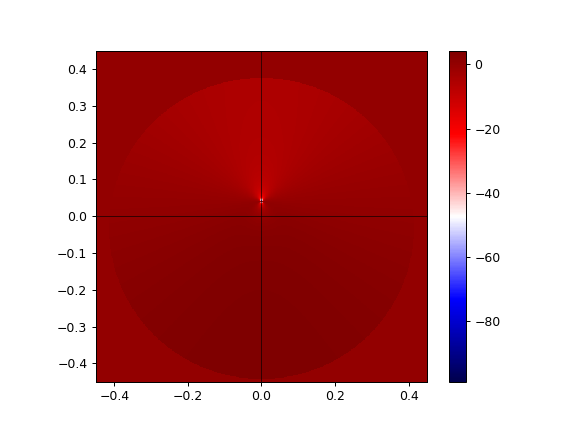

[-0.45, 0.45, -0.45, 0.45]
Inegral of SCV: 0.1968091613970337


In [59]:
band = 0
Ef = 100e-3

sgn_band = {0:-1, 1:1}[band]
nk= 600
kx_min, kx_max, ky_min, ky_max = limits_k_occup(Ef, alpha, B, band)
#print(kx_min, kx_max, ky_min, ky_max)
#kkx = np.linspace(kx_min, kx_max, nk)
#kky = np.linspace(ky_min, ky_max, nk)
#kx, ky = np.meshgrid(kkx, kky)
kmax = 4
k = np.linspace(-kmax, kmax, nk)
kx, ky = np.meshgrid(k, k)
omega = np.zeros_like(kx)
chi = np.zeros_like(kx)
Rashba = amod.Analytical_Rashba_model(alpha, B, 0.0)
for x in range(nk):
    for y in range(nk):
        energies = Rashba.rashba_energy(kx[x,y], ky[x,y])
        nF = bzu.fermi_dist(energies[band], Ef)
        omega[x,y] = nF * Rashba.omega_y(kx[x,y], ky[x,y], band)
        #chi[x,y] = np.imag(chi_k(kx[x,y], ky[x,y], alpha, B, phi))
        
integ_omega = integ.simps([integ.simps(omega_1d,k) for omega_1d in omega],k)
            
fig, ax = plt.subplots()
extent = [-kmax, kmax, -kmax, kmax]
print(extent)
img = ax.imshow(omega, origin="lower", cmap="seismic", extent = extent)
ax.axvline(color="black",lw=0.5)
ax.axhline(color="black",lw=0.5)

#k1 ,k2 = limits_k_occup(Ef, alpha, B, band)
#ax.scatter([0,0], [ky_min, ky_max], color="white")

plt.colorbar(img)


print("Inegral of SCV: {}".format(integ_omega))

## Analytical spin current against Ef

/home/orion178/Projects/2D-AFM-Top/analytical_models.py:303: RuntimeWarning: invalid value encountered in sqrt
  factor = (s1 + s2*np.sqrt(discr))


<IPython.core.display.Javascript object>


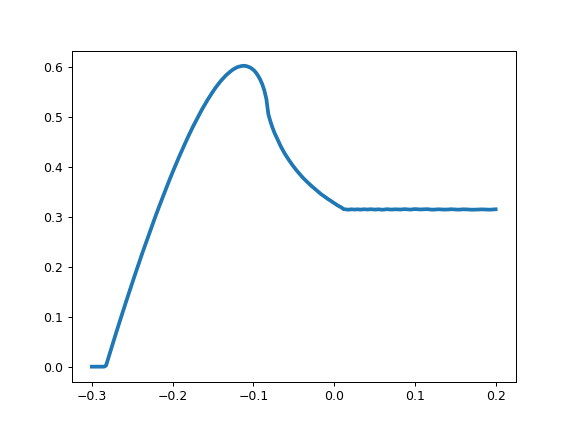

No handles with labels found to put in legend.


In [16]:
nE = 200
nk = 400
Ef_arr = np.linspace(-0.3, 0.2, nE)

#omega_arr_simps = np.zeros_like(Ef_arr)


for i in range(nE):
    Ef = Ef_arr[i]
    omega_bottom = integrated_omega_y(Ef, alpha, B, 0, nk=nk)
    omega_top = integrated_omega_y(Ef, alpha, B, 1, nk=nk)
    omega_arr_simps[i] = omega_bottom + omega_top

c = 0.0002423331459

dir_data = toy.ROOT_DIR / "saved_plots/rashba_model/integrated_SCV/"
np.save(dir_data / "Ef_arr.npy",Ef_arr)
np.save(dir_data / "omega_arr.npy", omega_arr_simps)

fig, ax = plt.subplots()
ax.plot(Ef_arr, omega_arr_simps, lw=3)
ax.legend(frameon=False)
plt.show()

## Numerical spin current against Ef
### To calculate spin conductivity, use rashba_spin_cond.py
### This cell is used to load and plot.

<IPython.core.display.Javascript object>


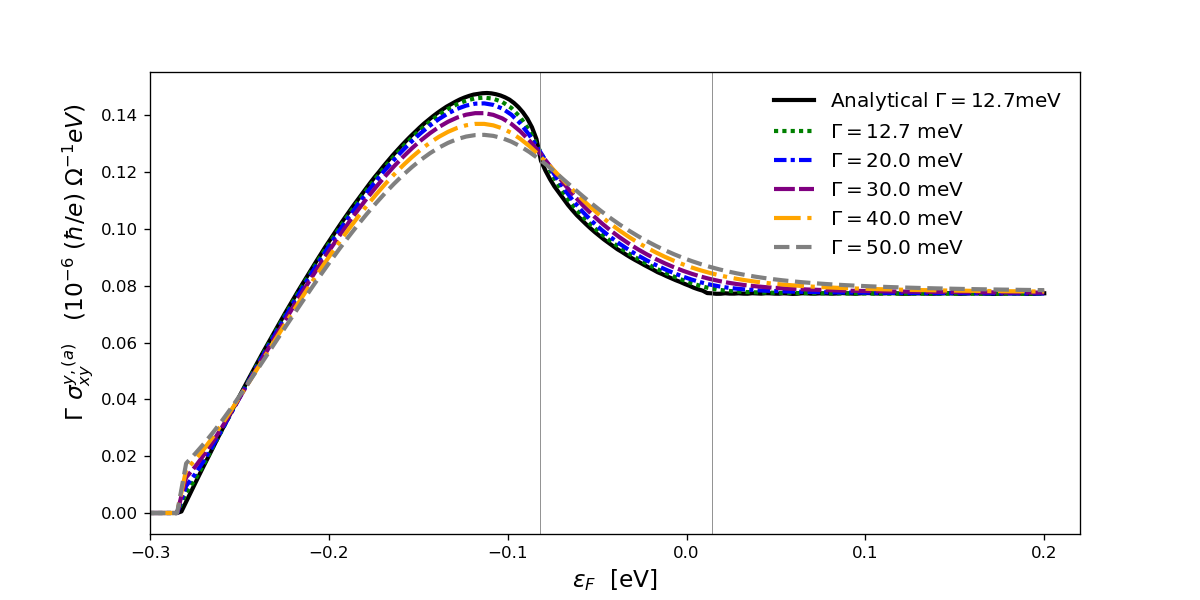

78.74015748031496


In [29]:
plot_opts = {1e-3:{"color":"red", "ls":"-."},
             12.7e-3:{"color":"green", "ls":(0,(1,1))},
             20e-3:{"color":"blue", "ls":(0, (3, 1, 1, 1))},
             30e-3:{"color":"purple", "ls":(0,(5,1))},
             40e-3:{"color":"orange", "ls":"-."},
             50e-3:{"color":"gray", "ls":"--"}
            }
mode = "zelezny"
Gamma_arr = np.array([12.7e-3, 20e-3, 30e-3, 40e-3, 50e-3])#, 30e-3])#, 40e-3, 50e-3])
fig, ax = plt.subplots(figsize=(10,5))
# Analytic plot
factor_numeric = factor_s * 1e6
factor_analytic = 1/(4)*factor_s * 1e6
ax.plot(Ef_arr, factor_analytic * omega_arr_simps, color="black", lw=2.5, ls="-", label=r"Analytical $\Gamma=12.7$meV")

component = (1,0,1)
for Gamma in Gamma_arr:
    str_G = np.round(Gamma*1e3, decimals=2)
	
    Ef_xy, s_cond_xy = Sim_rash.load_spin_conductivity_vs_Ef((1,0,1), Gamma, mode)
    Ef_yx, s_cond_yx = Sim_rash.load_spin_conductivity_vs_Ef((1,1,0), Gamma, mode)
    s_cond_xy[0:4] = 0
    s_cond_yx[0:4] = 0
    
    s_cond_a = 0.5 * (s_cond_xy - s_cond_yx) * factor_numeric
    s_cond_s = 0.5 * (s_cond_xy + s_cond_yx) * factor_numeric
    ax.plot(Ef_xy,  Gamma * s_cond_a, label=r"$\Gamma = {}$ meV".format(str_G), **plot_opts[Gamma], lw=2.5)




xlabel = r"$\varepsilon_F$  [eV]"
sigma_label = pltu.sigma_s_label(component, extra_sup=",(a)")
ax.set_xlabel(xlabel, fontsize=14)
label_G = r"           $\Gamma$ "
str_units = r"   ($10^{-6}$ $(\hbar/e)$ $\Omega^{-1} eV$)"
ax.set_ylabel(label_G + sigma_label + str_units, fontsize=14)
ax.legend(frameon=False, fontsize=12)
ax.set_xlim(left=-0.3, right=0.22)
Es = -82.0e-3
Ed = 14e-3
ax.axvline(Es, lw=0.5, color="gray")
ax.axvline(Ed, lw=0.5, color="gray")
print(1/12.7e-3)

## Loading and ploting analytical Magnetic Spin hall Effect

<IPython.core.display.Javascript object>


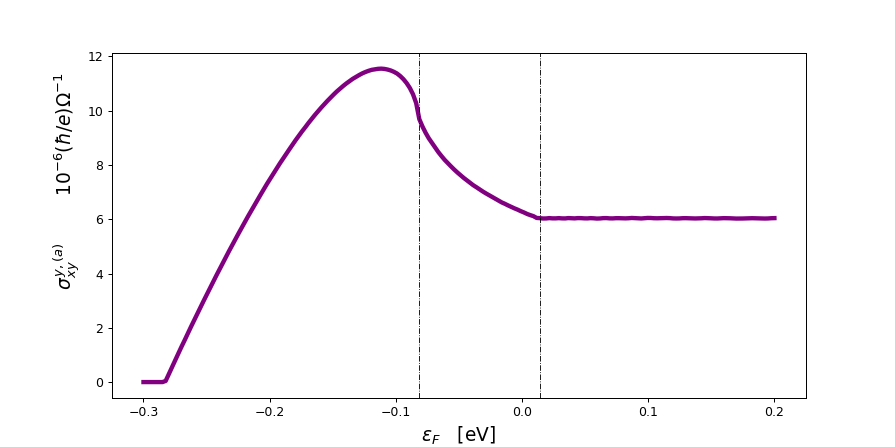

In [55]:
dir_data = toy.ROOT_DIR / "saved_plots/rashba_model/integrated_SCV/"

Ef_arr = np.load(dir_data / "Ef_arr.npy")
omega_arr_simps = np.load(dir_data / "omega_arr.npy")
Gamma = 12.8e-3
factor_analytic = factor_s / (2*Gamma) * 1e6 / 2
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(Ef_arr, factor_analytic * omega_arr_simps, color="purple", lw=3.5) 
#ax.legend(frameon=False)
ax.set_xlabel(r"$\varepsilon_{F}$   [eV]", fontsize=15)
ax.set_ylabel(r"               $\sigma^{y, (a)}_{xy}$        $10^{-6}(\hbar / e)\Omega^{-1}$", fontsize=15)
ax.axvline(x=14e-3, color="black", lw=0.7, ls="-.")
ax.axvline(x=-82e-3, color="black", lw=0.7, ls="-.")
plt.show()

# Comparing Zelezny and Mook expressions for odd conductivity

In [6]:
Gamma = 12.7e-3
Ef = 0.035
nk = 500
component = (1,0,1)
Sim_rash.mode_s_cond = "zelezny_intra"
zelezny = Sim_rash.spin_conductivity(Ef, component, Gamma=Gamma, nk=nk)
#Sim_rash.mode_s_cond = "mook"
#mook = Sim_rash.spin_conductivity(Ef, component, Gamma=Gamma, nk=nk)

Sim_rash.mode_s_cond = "mook_intra"
mook_intra = Sim_rash.spin_conductivity(Ef, component, Gamma=Gamma, nk=nk)

#Sim_rash.mode_s_cond = "mook_inter"
#mook_inter = Sim_rash.spin_conductivity(Ef, component, Gamma=Gamma, nk=nk)

print("Zelezny: ", zelezny)
#print("Mook: ", mook)
print("Mook intra: ", mook_intra)
print("z/m:", zelezny/mook_intra)
#print("Mook inter: ", mook_inter)
#print("Mook intra+inter: ", mook_intra+mook_inter)

Zelezny:  5.497949729685782
Mook intra:  10.45127224350785
z/m: 0.5260555463093035


In [5]:
zelezny /mook_intra

0.514488628756797

In [5]:
mook /zelezny

-1.9439712720663653

In [3]:
def zelezny_vs_mook_intra(Ef, Gamma, nk=200):
    component = (1,0,1)
    Sim_rash.mode_s_cond = "zelezny_intra"
    zelezny_intra = Sim_rash.spin_conductivity(Ef, component, Gamma=Gamma, nk=nk)

    Sim_rash.mode_s_cond = "mook_intra"
    mook_intra = Sim_rash.spin_conductivity(Ef, component, Gamma=Gamma, nk=nk)
    return zelezny_intra, mook_intra

def zelezny_vs_mook_inter(Ef, Gamma, nk=200):
    component = (1,0,1)
    Sim_rash.mode_s_cond = "zelezny_inter"
    zelezny_inter = Sim_rash.spin_conductivity(Ef, component, Gamma=Gamma, nk=nk)

    Sim_rash.mode_s_cond = "mook_inter"
    mook_inter = Sim_rash.spin_conductivity(Ef, component, Gamma=Gamma, nk=nk)
    return zelezny_inter, mook_inter


def zelezny_mook_intra_Ef(Gamma, nk=100, nE=5):
    Ef_arr = np.linspace(-0.3, 0.1, nE)
    z_vs_m = np.zeros((3,nE))
    dir_test = Sim_rash.path / "zelezny_vs_mook"
    toy.mk_dir(dir_test)
    str_G = np.round(Gamma*1e3, 2)
    name = "zelezny_vs_mook_Gamma={}meV.npy".format(str_G)
    for i in range(nE):
        Ef = Ef_arr[i]
        z_vs_m[0,i] = Ef
        z, m = zelezny_vs_mook_intra(Ef, Gamma, nk=nk)
        z_vs_m[1,i] = z
        z_vs_m[2,i] = m
    np.save(dir_test / name, z_vs_m)
    
def load_zelezny_mook_Ef(Gamma):
    dir_test = Sim_rash.path / "zelezny_vs_mook"
    str_G = np.round(Gamma*1e3, 2)
    name = "zelezny_vs_mook_Gamma={}meV.npy".format(str_G)
    z_vs_m = np.load(dir_test / name)
    return z_vs_m

In [4]:
Gamma = 15e-3
nk = 300
nE = 50
zelezny_mook_intra_Ef(Gamma, nk=nk, nE=nE)


/home/orion178/Projects/2D-AFM-Top/analytical_models.py:298: RuntimeWarning: invalid value encountered in sqrt
  factor = (s1 + s2*np.sqrt(discr))


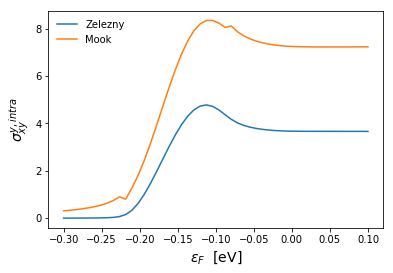

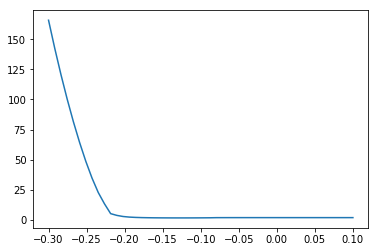

In [6]:
fig, ax = plt.subplots()
z_vs_m = load_zelezny_mook_Ef(Gamma)
ax.plot(z_vs_m[0,:], z_vs_m[1,:], label="Zelezny")
ax.plot(z_vs_m[0,:], z_vs_m[2,:], label="Mook")

ax.set_xlabel(r"$\varepsilon_F$  [eV]", fontsize=14)
sigma_label = pltu.sigma_s_label((1,0,1), extra_sup=", intra")
ax.set_ylabel(sigma_label, fontsize=14)
ax.legend(frameon=False)


fig2, ax2 = plt.subplots()
ax2.plot(z_vs_m[0,:], z_vs_m[2,:] / z_vs_m[1,:], label="Zelezny/Mook")


## Charge conductivity

<IPython.core.display.Javascript object>


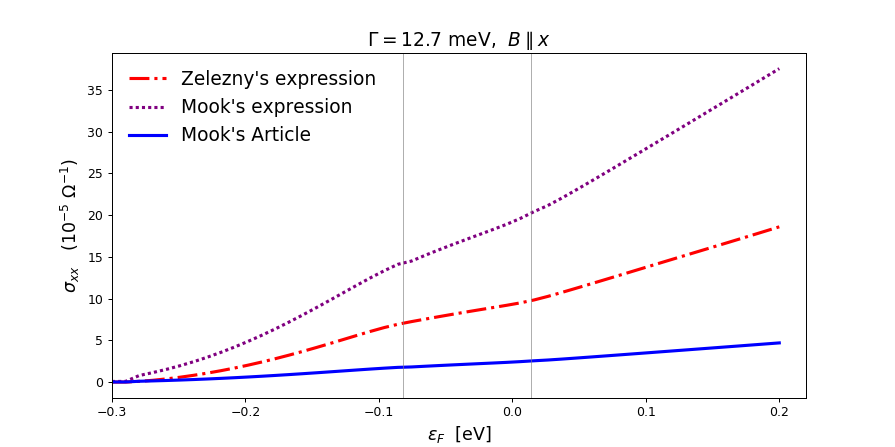

Text(0.5,1,'$\\Gamma = 12.7$ meV,  $B \\parallel x$')

In [52]:
plot_opts = {"odd_z":{"color":"red", "ls":"-."},
             "odd_m":{"color":"purple", "ls":(0,(1,1))},
             "even_z":{"color":"blue", "ls":(0, (3, 1, 1, 1))},
             "even_m":{"color":"green", "ls":(0,(5,1))},
             "article":{"color":"blue", "ls":"-"}
            }

label_dict = {"odd_z": "Zelezny's expression",
             "odd_m": "Mook's expression",
             "article":"Mook's Article"}


add_extra_factor = False


Gamma = 12.7e-3
str_G = np.round(Gamma*1e3, decimals=2)
mode_arr = ["odd_z", "odd_m", "article"] #["odd_z", "odd_m", "even_z", "even_m"]
fig, ax = plt.subplots(figsize=(10,5))
factor_numeric = factor_s * 1e5
extra_factors = {"odd_z":1/4, "odd_m":1/8, "article":1} if add_extra_factor else {"odd_z":1, "odd_m":1, "article":1}

component = (0,0)
for mode in mode_arr:
    if mode=="article":
        Ef_arr, c_cond_xx = Sim_rash.load_charge_conductivity_vs_Ef(component, Gamma, "odd_m")
        c_cond_xx = c_cond_xx / 8
    else:
        Ef_arr, c_cond_xx = Sim_rash.load_charge_conductivity_vs_Ef(component, Gamma, mode)
    c_cond_xx = c_cond_xx * factor_numeric * extra_factors[mode]
    
    ax.plot(Ef_arr,  c_cond_xx, label=label_dict[mode], **plot_opts[mode], lw=2.5)




xlabel = r"$\varepsilon_F$  [eV]"
sigma_label = pltu.sigma_s_label(component)
ax.set_xlabel(xlabel, fontsize=14)

str_units = r"   ($10^{-5}$ $\Omega^{-1}$)"
ax.set_ylabel(sigma_label + str_units, fontsize=14)
ax.legend(frameon=False, fontsize=15)
ax.set_xlim(left=-0.3, right=0.22)
Es = -82.0e-3
Ed = 14e-3
ax.axvline(Es, lw=0.5, color="gray")
ax.axvline(Ed, lw=0.5, color="gray")

ax.set_title(r"$\Gamma = 12.7$ meV,  $B \parallel x$", fontsize=15)


## Spin conductivity: Comparison between Mook's and Zelezny's expressions

<IPython.core.display.Javascript object>


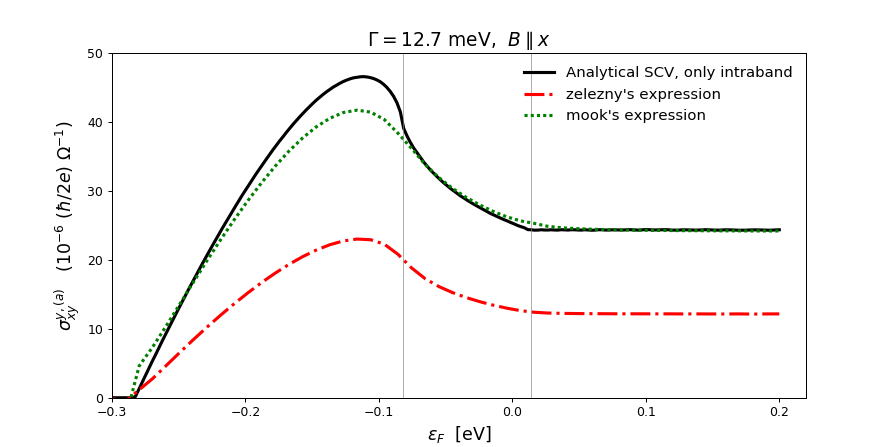

Text(0.5,1,'$\\Gamma = 12.7$ meV,  $B \\parallel x$')

In [60]:
plot_opts = {"zelezny":{"color":"red", "ls":"-."},
             "mook":{"color":"green", "ls":(0,(1,1))}
            }
mode_arr = ["zelezny", "mook"]
Gamma = 12.7e-3
str_G = np.round(Gamma*1e3, decimals=2)
fig, ax = plt.subplots(figsize=(10,5))


# Analytic plot
factor_numeric = factor_s * 1e6 * 2
factor_analytic = 1/(2)*factor_s * 1e6 / Gamma * 2
ax.plot(Ef_arr, factor_analytic * omega_arr_simps, color="black", lw=2.5, ls="-", label=r"Analytical SCV, only intraband")

component = (1,0,1)
for mode in mode_arr:
    Ef_xy, s_cond_xy = Sim_rash.load_spin_conductivity_vs_Ef((1,0,1), Gamma, mode)
    Ef_yx, s_cond_yx = Sim_rash.load_spin_conductivity_vs_Ef((1,1,0), Gamma, mode)
    
    s_cond_a = 0.5 * (s_cond_xy - s_cond_yx) * factor_numeric
    s_cond_s = 0.5 * (s_cond_xy + s_cond_yx) * factor_numeric
    ax.plot(Ef_xy, s_cond_a, label=r"{}'s expression".format(mode), **plot_opts[mode], lw=2.5)




xlabel = r"$\varepsilon_F$  [eV]"
sigma_label = pltu.sigma_s_label(component, extra_sup=",(a)")
ax.set_xlabel(xlabel, fontsize=14)

str_units = r"   ($10^{-6}$ $(\hbar/2e)$ $\Omega^{-1}$)"
ax.set_ylabel(sigma_label + str_units, fontsize=14)
ax.legend(frameon=False, fontsize=12)
ax.set_xlim(left=-0.3, right=0.22)
Es = -82.0e-3
Ed = 14e-3
ax.axvline(Es, lw=0.5, color="gray")
ax.axvline(Ed, lw=0.5, color="gray")
ax.set_ylim(0.0, 50)

ax.set_title(r"$\Gamma = 12.7$ meV,  $B \parallel x$", fontsize=15)